<a href="https://colab.research.google.com/github/MartinSomsak00/MLF/blob/main/project_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()

# Extract the uploaded ZIP file
zip_filename = list(uploaded.keys())[0]
extract_path = "/content/MPA-MLF_DATA_NEW"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List files for confirmation
print("Extracted contents:", os.listdir(extract_path))


Saving MPA-MLF_DATA_NEW.zip to MPA-MLF_DATA_NEW.zip
Extracted contents: ['Train', 'label_train.csv', 'Test', 'test_format.csv']


In [5]:
print("Column names in label_train.csv:")
print(label_df.columns)


Column names in label_train.csv:
Index(['ID', 'target'], dtype='object')


Loaded sample shape: (72, 48)


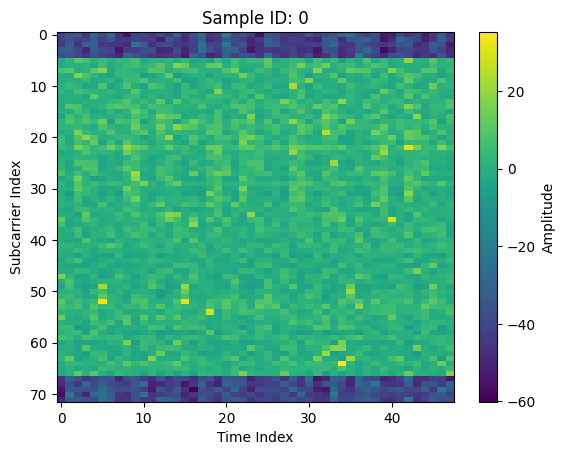

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
data_path = "/content/MPA-MLF_DATA_NEW"
train_folder = os.path.join(data_path, "Train")
test_folder = os.path.join(data_path, "Test")

# Load label CSV
import pandas as pd
label_df = pd.read_csv(os.path.join(data_path, 'label_train.csv'))

# Use the 'ID' column to construct filename
sample_id = label_df.iloc[0]['ID']
filename = f"{sample_id}.npy"
sample_file = os.path.join(train_folder, filename)
sample_data = np.load(sample_file)

print(f"Loaded sample shape: {sample_data.shape}")

# Plot the sample
plt.imshow(sample_data, aspect='auto', cmap='viridis')
plt.title(f"Sample ID: {sample_id}")
plt.colorbar(label='Amplitude')
plt.xlabel('Time Index')
plt.ylabel('Subcarrier Index')
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load all training samples
X = []
y = []

for _, row in tqdm(label_df.iterrows(), total=len(label_df)):
    file_id = row['ID']
    label = row['target']
    file_path = os.path.join(train_folder, f"{file_id}.npy")
    data = np.load(file_path)
    X.append(data)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)  # Shape: (num_samples, 72, 48)
y = np.array(y)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


100%|██████████| 1491/1491 [00:00<00:00, 3330.01it/s]

Data shape: (1491, 72, 48), Labels shape: (1491,)


In [8]:
# Normalize each sample independently
X_mean = X.mean(axis=(1, 2), keepdims=True)
X_std = X.std(axis=(1, 2), keepdims=True)
X_norm = (X - X_mean) / (X_std + 1e-8)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (1192, 72, 48), Validation shape: (299, 72, 48)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Reshape input data to add channel dimension
X_train_cnn = X_train[..., np.newaxis]  # (N, 72, 48, 1)
X_val_cnn = X_val[..., np.newaxis]

# Define CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 70, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 70, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 33, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,310,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,177 (5.07 MB)

 Trainable params: 1,329,985 (5.07 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
history = model.fit(X_train_cnn, y_train,
                    validation_data=(X_val_cnn, y_val),
                    epochs=20,
                    batch_size=32)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.7603 - loss: 1.9660 - val_accuracy: 0.0936 - val_loss: 16.3304
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.8618 - loss: -5.6848 - val_accuracy: 0.0936 - val_loss: 212.1265
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8823 - loss: -55.1348 - val_accuracy: 0.0936 - val_loss: 1295.8776
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8665 - loss: -345.3223 - val_accuracy: 0.0936 - val_loss: 4618.1421
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.8559 - loss: -945.0995 - val_accuracy: 0.0936 - val_loss: 10930.6621
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.8649 - loss: -2014.6918 - val_accuracy: 0.0936 - val_loss: 21007.5254
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.8641 - loss: -3522.2166 - val_accuracy: 0.0936 - val_loss: 34493.4883
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy

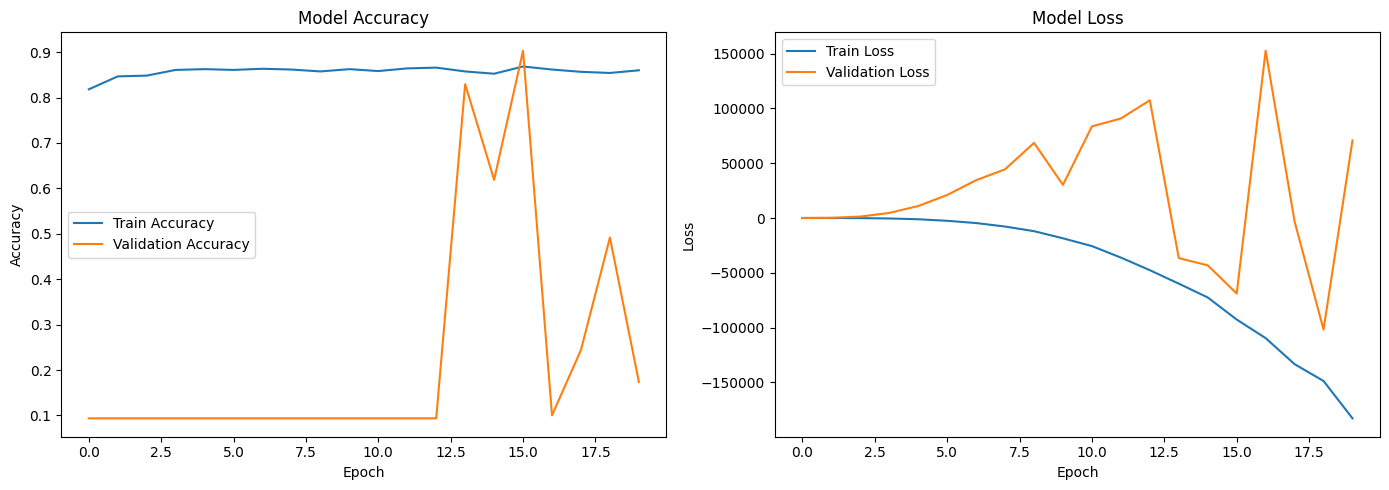

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
